In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

## Logistic Regression

Text(0, 0.5, 'logistic(z)')

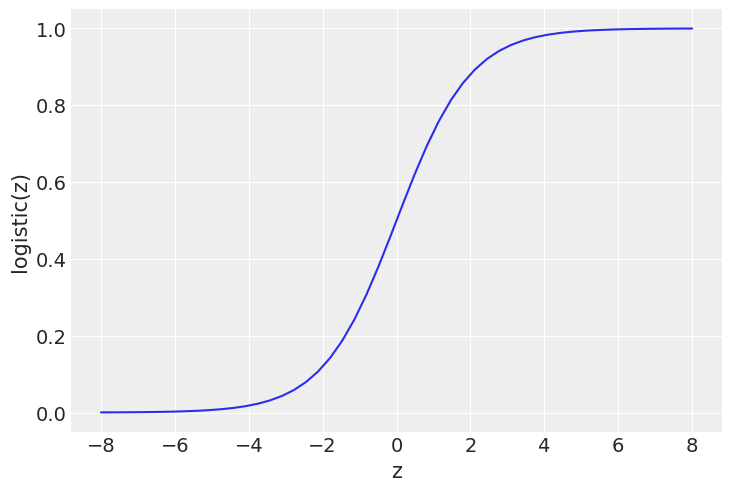

In [3]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')

iris dataset을 이용하여 logistic regression 구성

In [4]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<AxesSubplot:xlabel='species', ylabel='sepal_length'>

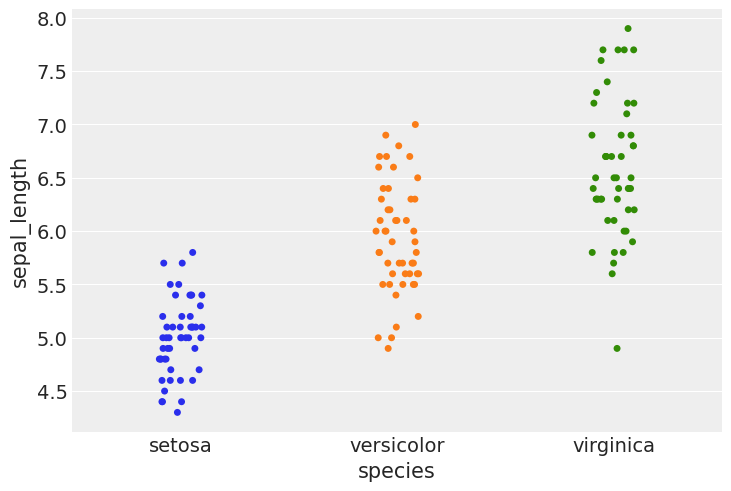

In [5]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
# jitter=True 이용시 겹치는 점에 대해 어느정도 잘 보이도록 해줌

<AxesSubplot:xlabel='species', ylabel='sepal_length'>

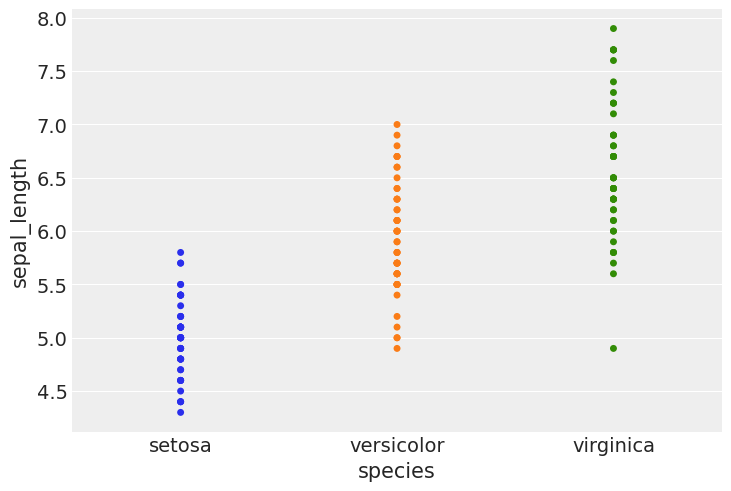

In [6]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=False)

C:\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


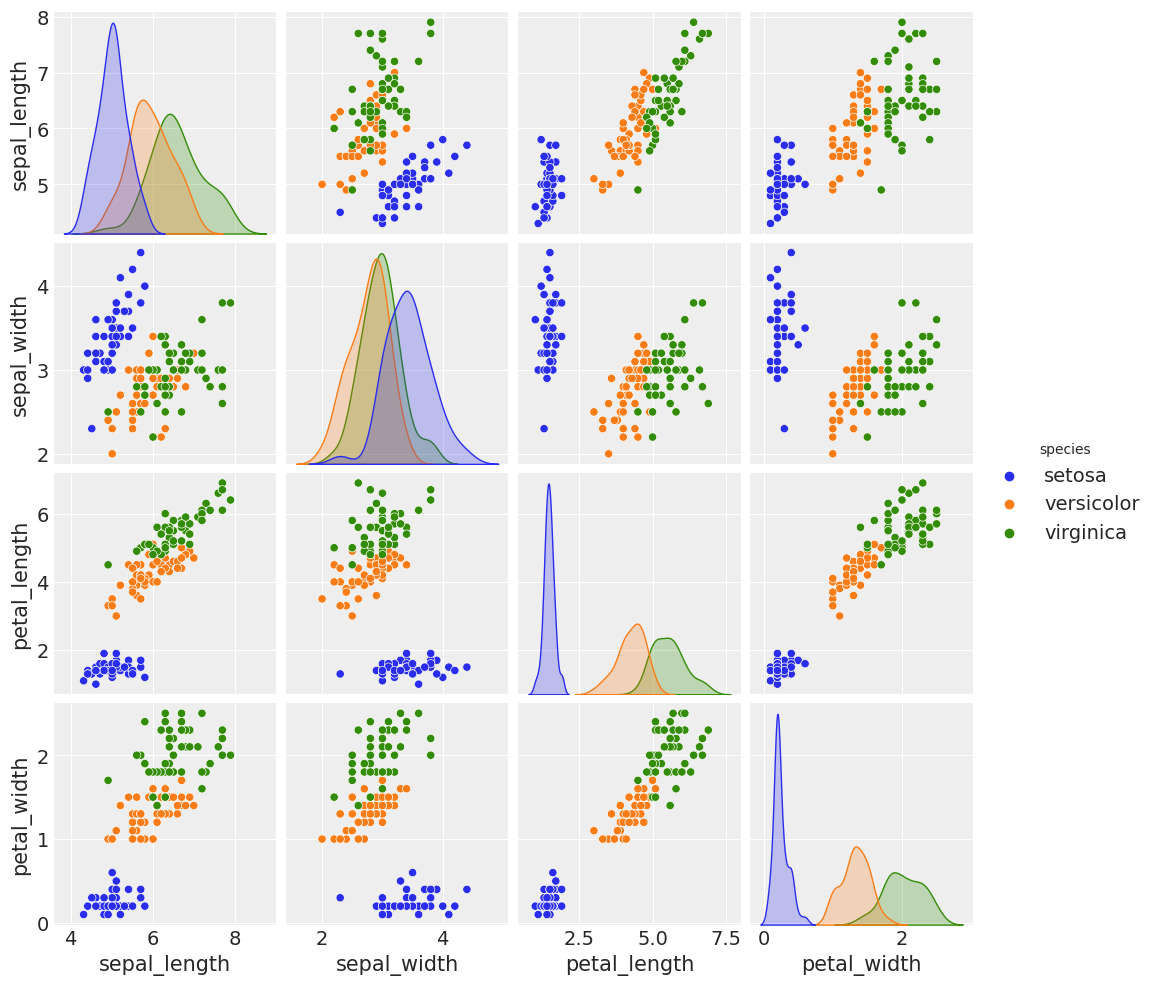

In [7]:
sns.pairplot(iris, hue='species', diag_kind='kde')

## Logistic Model with Iris dataset

In [8]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

setosa와 versicolor 두 품종에 대해 logistic 분류 모델 생성

In [9]:
with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    idata_0 = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [10]:
varnames = ['α', 'β', 'bd']
az.summary(idata_0, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.316,0.347,-0.344,0.949,0.007,0.005,2828.0,2421.0,1.0
β,5.392,1.068,3.636,7.533,0.022,0.016,2352.0,2195.0,1.0
bd,-0.057,0.063,-0.172,0.063,0.001,0.001,2799.0,2516.0,1.0


C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


([<matplotlib.axis.XTick at 0x1a2dcdc9870>,
 [Text(-1.5, 0, '4.0'),
  Text(-1.0, 0, '4.5'),
  Text(-0.5, 0, '5.0'),
  Text(0.0, 0, '5.5'),
  Text(0.5, 0, '6.0'),
  Text(1.0, 0, '6.5'),
  Text(1.5, 0, '7.0'),
  Text(2.0, 0, '7.5')])

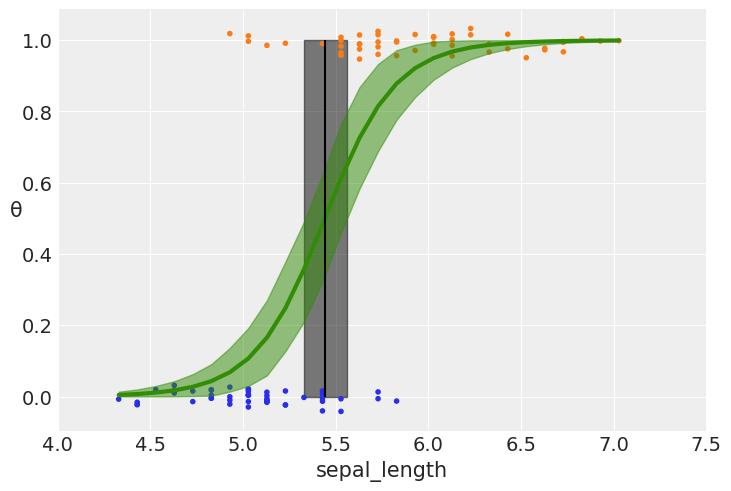

In [11]:
posterior_0 = idata_0.posterior.stack(samples=("chain", "draw"))

theta = posterior_0['θ'].mean("samples")
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hdi(posterior_0['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, posterior_0['θ'].T, color='C2', smooth=False)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

검은색 수직선의 경우 클래스를 결정짓는 Boundary Decision  
녹색의 경우 sigmoid 함수를 거친 확률값, 옅은 부분은 94% hpd를 의미한다.

## Multiple Logistic Regression

In [12]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [13]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    idata_1 = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 75 seconds.


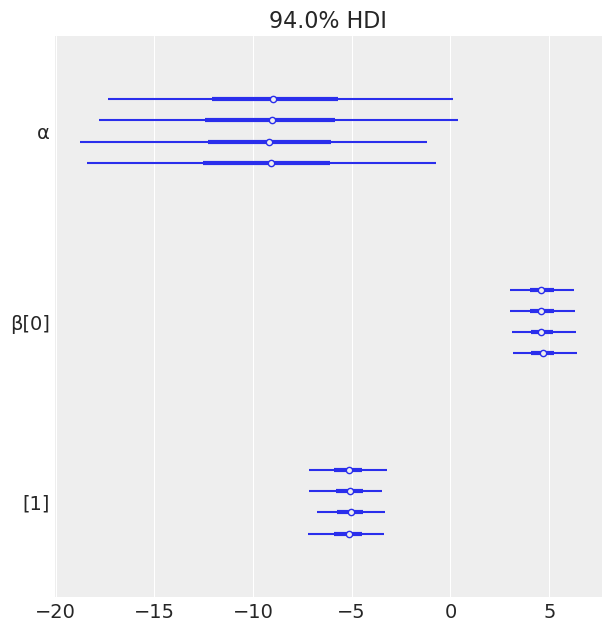

In [14]:
varnames = ['α', 'β'] 
az.plot_forest(idata_1, var_names=varnames);

Text(0, 0.5, 'sepal_width')

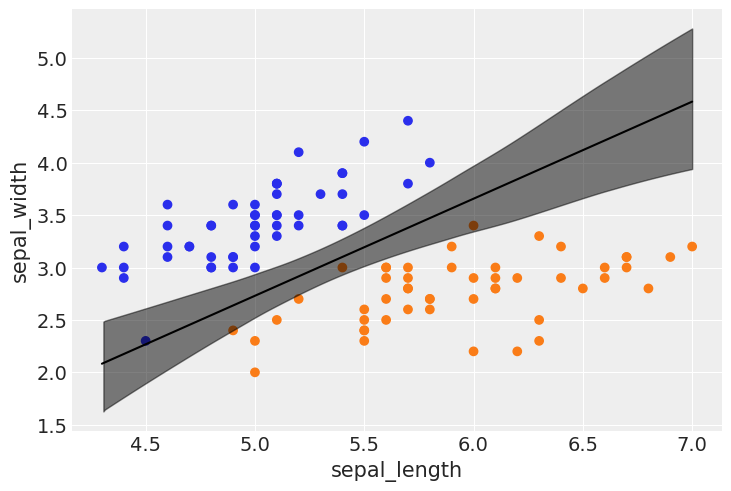

In [15]:
idx = np.argsort(x_1[:,0]) 
bd = idata_1.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hdi(x_1[:,0], idata_1.posterior['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

## Interpreting the coefficients of a logistic regression

$\ z = (1+exp(-f(x))) $ 이고 이때 $\ f(x) $를 logit, $\ z/(1-z) $를 odds 라고 한다.

C:\Users\User\AppData\Local\Temp\ipykernel_16312\756753131.py:2: RuntimeWarning: divide by zero encountered in true_divide
  odds = prob / (1 - prob)


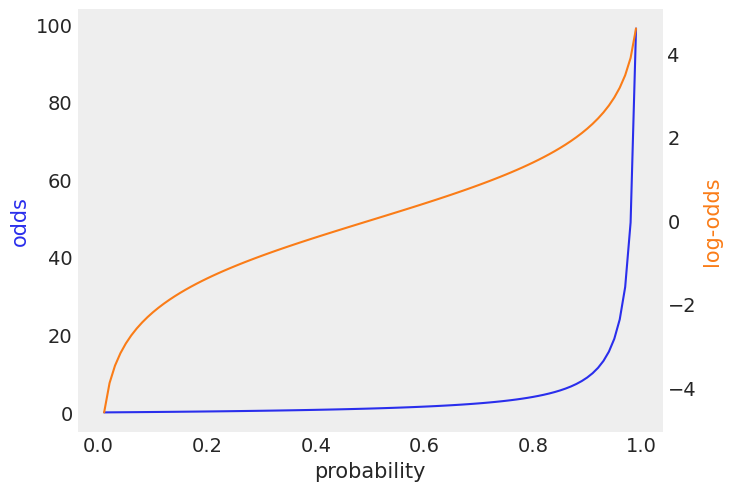

In [16]:
prob = np.linspace(0.01, 1, 100)
odds = prob / (1 - prob)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(prob, odds, 'C0')
ax2.plot(prob, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)

odds 와 log-odds를 비교하여 그림

In [17]:
df = az.summary(idata_1, var_names=varnames)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-9.149,4.714,-18.301,-0.419,0.090,0.064,2760.0,2987.0,1.0
β[0],4.667,0.876,3.018,6.295,0.016,0.012,2914.0,2816.0,1.0
β[1],-5.180,1.012,-7.163,-3.421,0.019,0.014,3230.0,2574.0,1.0


In [18]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
# log odd 구하기
probability_versicolor_i = logistic(log_odds_versicolor_i)
# 확률 구하기

log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

f"{log_odds_versicolor_f - log_odds_versicolor_i:.2f}", f"{probability_versicolor_f - probability_versicolor_i:.2f}"

('4.67', '0.70')

x_1 = 4.5, x_2 = 3 이면 B.D를 참고하면 setosa로 분류한다.  
x_1에 1을 더하면 $ \beta[0] $ 만큼 log_odd 가 늘어나고, 최종적인 확률값의 경우 0.7이 늘어난다. 즉 $ \beta $만큼 x가 늘어남에 따라 log-odds 가 늘어나는 정도를 결정한다.

## Correlated 변수들 다루기

<AxesSubplot:>

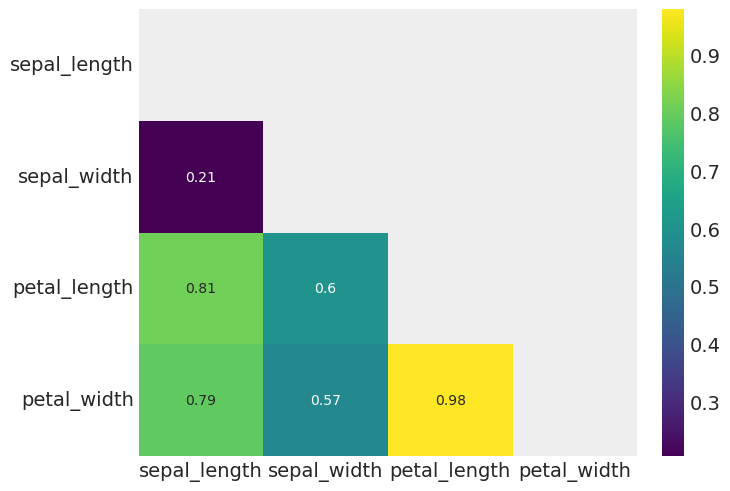

In [19]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

다음과 같이 상관계수가 높은 데이터들이 있다.  
이러한 데이터들을 다루는 방법에는 크게 두 가지가 있다.  
https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations  
다음 사이트에서 prior 확인 가능

## Dealing unbalanced classes

logistic regression의 경우 unbalanced data에 prune 하다.

In [20]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [21]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    idata_3 = pm.sample(1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


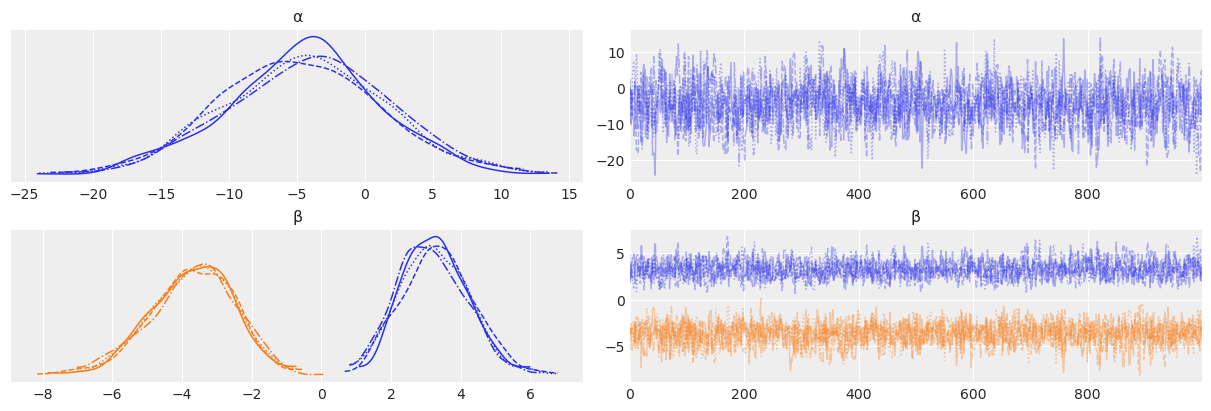

In [22]:
az.plot_trace(idata_3, varnames);

Text(0, 0.5, 'sepal_width')

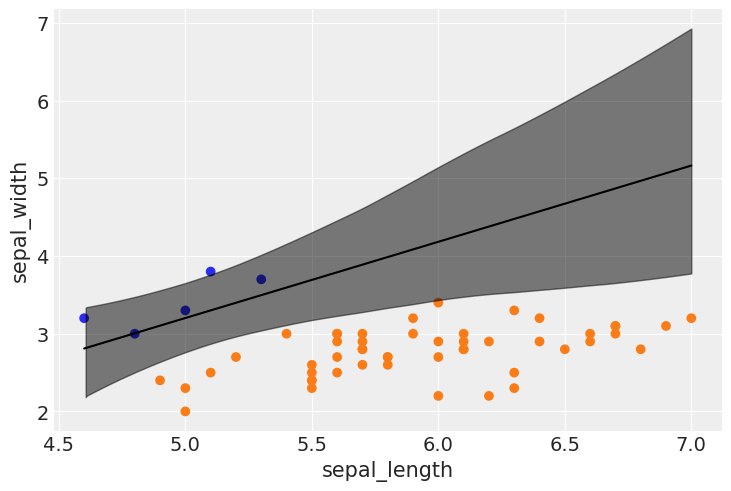

In [23]:
idx = np.argsort(x_3[:,0]) 
bd = idata_3.posterior['bd'].mean(("chain", "draw"))[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hdi(x_3[:,0], idata_3.posterior['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

unbalanced data에 의해 D.B가 넓어졌다.  
따라서 unbalanced data가 있는 경우 이를 조정을 해주어야 한다.

## Softmax Regression

class가 2개보다 많은 경우 이용하는 것이 softmax regression 이다.  
softmax 함수의 경우 통계물리학에서 볼츠만 분포와 똑같다.  
여러 class 분류의 경우 logistic 함수를 softmax 함수로,  
그리고 마지막 $\theta$에 대한 분포를 베르누이 분포에서 categorical 분포로 바꾸어주어야 한다.

In [24]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [25]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_s = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 131 seconds.


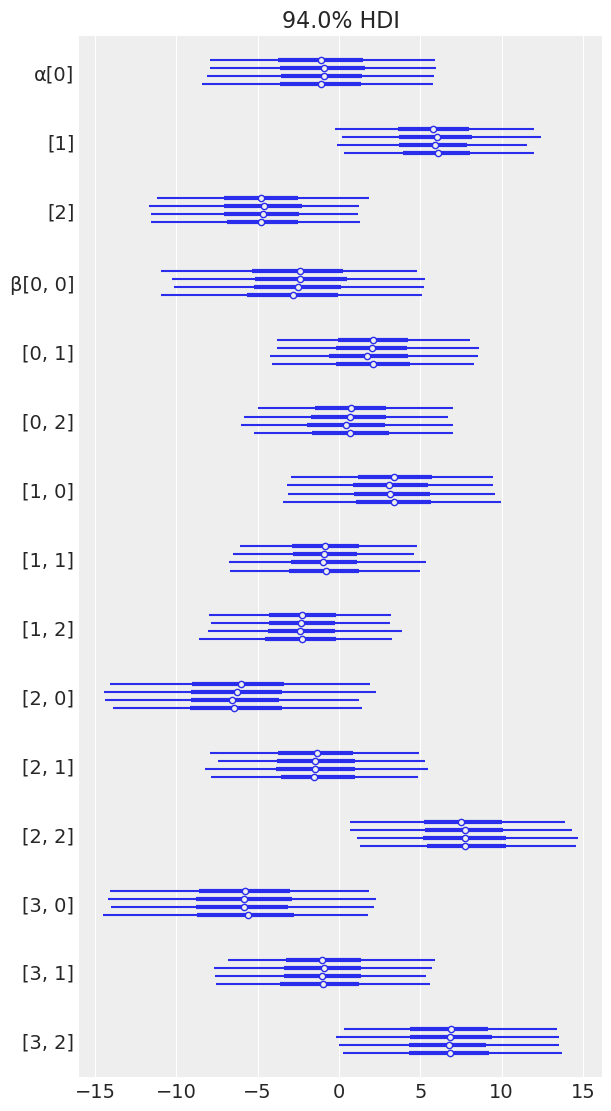

In [26]:
az.plot_forest(idata_s, var_names=['α', 'β']);

In [27]:
data_pred = idata_s.posterior['μ'].mean(("chain", "draw"))

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]
# 정확도 측정. 98% 의 확률로 원래 클래스로 예측
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [28]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    idata_sf = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


## Discriminative & Generative Models

Discriminative - $\ p(y|x) $ 즉 x를 알때 클래스의 확률을 예측  
Generative - $\ p(x|y) $ 각각의 클래스에 대한 x의 분포를 예측  

In [29]:
with pm.Model() as lda:# Linear Discriminant Analysis
    μ = pm.Normal('μ', mu=0, sd=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    # B.D를 구성할 Gaussian 분포
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ,
                           observed=x_0[50:])
    # B.D를 Gaussian 분포의 평균들로 구성
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    idata_lda = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


LDA모델은 generative model이다.  
즉 클래스로 부터 데이터들을 생성가능

Text(0.5, 0, 'sepal_length')

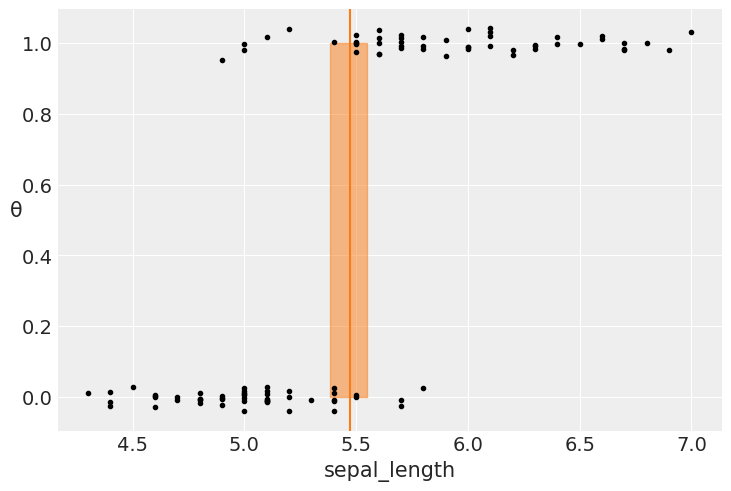

In [30]:
posterior_lda = idata_lda.posterior.stack(samples=("chain", "draw"))
plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')

In [31]:
az.summary(idata_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],5.005,0.064,4.887,5.126,0.001,0.001,4530.0,3145.0,1.0
μ[1],5.936,0.064,5.818,6.053,0.001,0.001,6023.0,3200.0,1.0
σ,0.448,0.033,0.392,0.511,0.000,0.000,5361.0,2967.0,1.0
bd,5.470,0.045,5.382,5.548,0.001,0.000,4761.0,2810.0,1.0


Feature들이 Gaussian 분포를 어느정도 따를때, generative model이 더 좋고, 단순 선형 형태일 경우 Logistic Regression이 더 좋다.

## Poisson distribution

poisson 분포의 경우 시간 또는 공간마다 발생하는 사건을 세기위해 나왔다.  
$\ f(x|\mu) = exp(-\mu)*\mu^x / x!$ 로 쓸 수 있고  
$\mu$가 정해진 시간간격, 공간간격에서 일어나는 사건의 기대값이다.

Text(0, 0.5, 'f(x)')

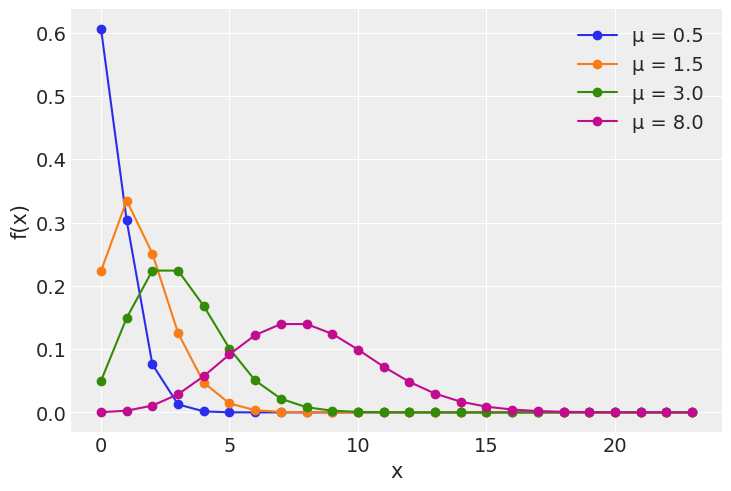

In [32]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

포아송분포의 경우 이항분포의 특이 케이스로 볼 수 있다.  
$\mu$가 매우크고, p가 낮을때 이항분포로 근사시켜 볼 수 있다.  
이때 X ~ Bin(n, p)고, p가 작을때, 이 분포는 X ~ Poisson($\mu$=np)로 생각가능

## Zero-Inflated Poisson model

p(y = 0) = 1 - $\psi + (\psi)exp(-\mu)$  
p(y = k) = $\psi*exp(-\mu)*\mu^x / x!$  
zero-inflated possion은 2개의 모수를 가지고 있고, 대부분의 관측치가 0에 몰려있으며 0이 아닌 관측치들이 포아송 분포를 따르는 케이스 이다.

In [33]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * 
                   np.random.poisson(θ_real) for i in range(n)])

In [34]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ,
                               observed=counts)
    idata = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


array([[<AxesSubplot:title={'center':'ψ'}>,
        <AxesSubplot:title={'center':'ψ'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

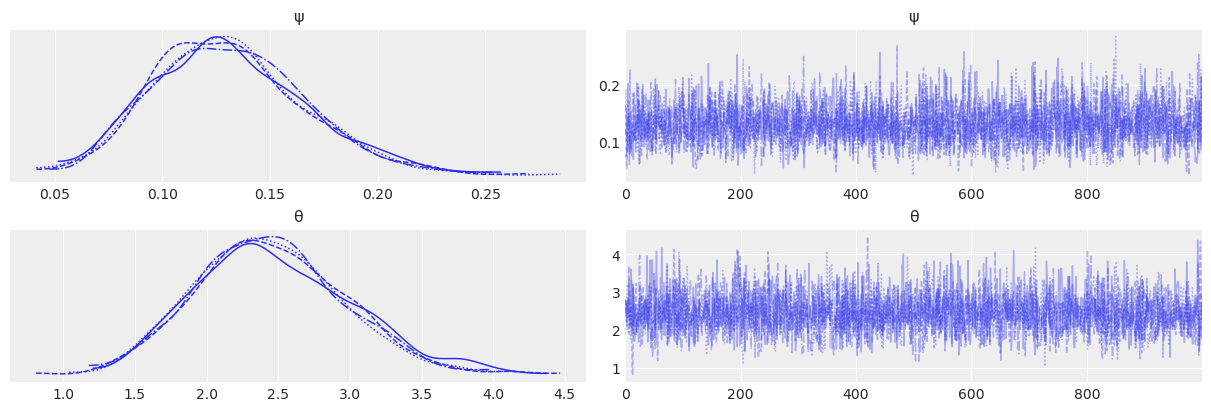

In [35]:
az.plot_trace(idata)

In [36]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ψ,0.131,0.035,0.071,0.201,0.001,0.000,2937.0,2624.0,1.0
θ,2.451,0.523,1.523,3.432,0.010,0.007,2757.0,2238.0,1.0


## Poisson regression and ZIP regression

In [37]:
fish_data = pd.read_csv('data/fish.csv')

In [38]:
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


결과가 단위 시간이나 공간안에 몇번 발생할지에 대해 볼때 포아송 회귀를 이용.  
$\theta = exp(\alpha + X\beta)$를 이용하여 theta(얼마나 일어나는지) 추정

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, ψ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


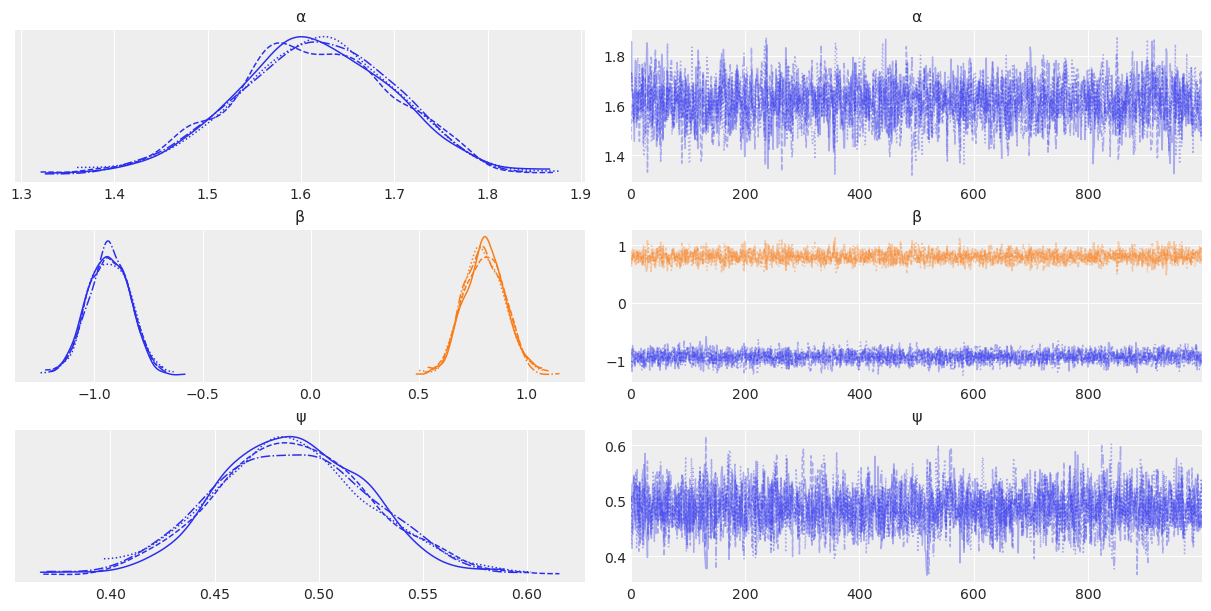

In [39]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    idata_ZIP_reg = pm.sample(1000, return_inferencedata=True)
az.plot_trace(idata_ZIP_reg);

In [40]:
az.summary(idata_ZIP_reg)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.614,0.086,1.458,1.775,0.002,0.001,2327.0,2280.0,1.0
β[0],-0.933,0.096,-1.111,-0.756,0.002,0.001,3060.0,2449.0,1.0
β[1],0.805,0.095,0.632,0.979,0.002,0.001,2324.0,1966.0,1.0
ψ,0.487,0.036,0.422,0.558,0.001,0.000,2869.0,2321.0,1.0


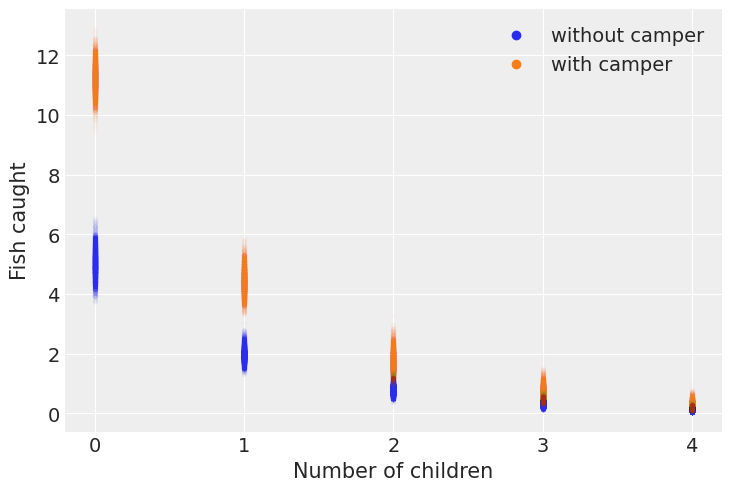

In [41]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

posterior_ZIP_reg = idata_ZIP_reg.posterior.stack(samples=("chain", "draw"))

for n in children:
    without_camper = posterior_ZIP_reg['α'] + posterior_ZIP_reg['β'].values[0] * n
    with_camper = without_camper + posterior_ZIP_reg['β'].values[1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()

## Robust logistic regression

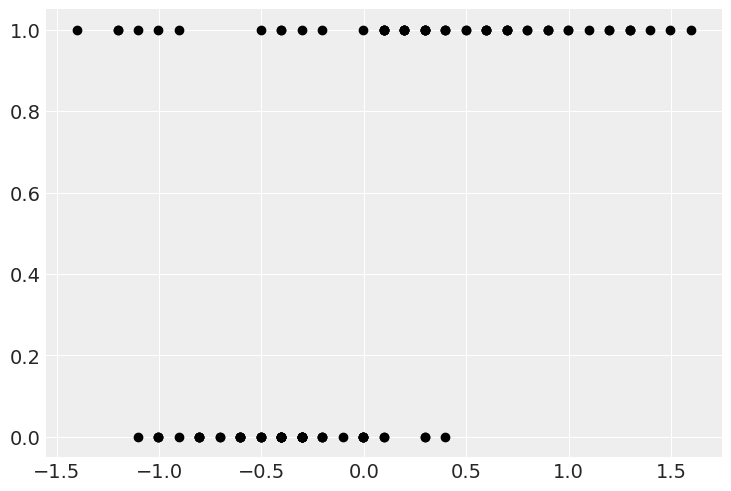

In [42]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

$p=\pi 0.5+ (1-\pi)logistic(\alpha + X\beta)$  
와 같이 식을 바꾸어 logistic regression을 조금 더 robust 하게 바꿔줄 수 있다.  
$\pi$가 1 일때 p값은 0.5가 나오고, 0일때 우리가 아는 logistic 회귀식이 나온다.

In [43]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1., 1.) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    idata_rlg = pm.sample(1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


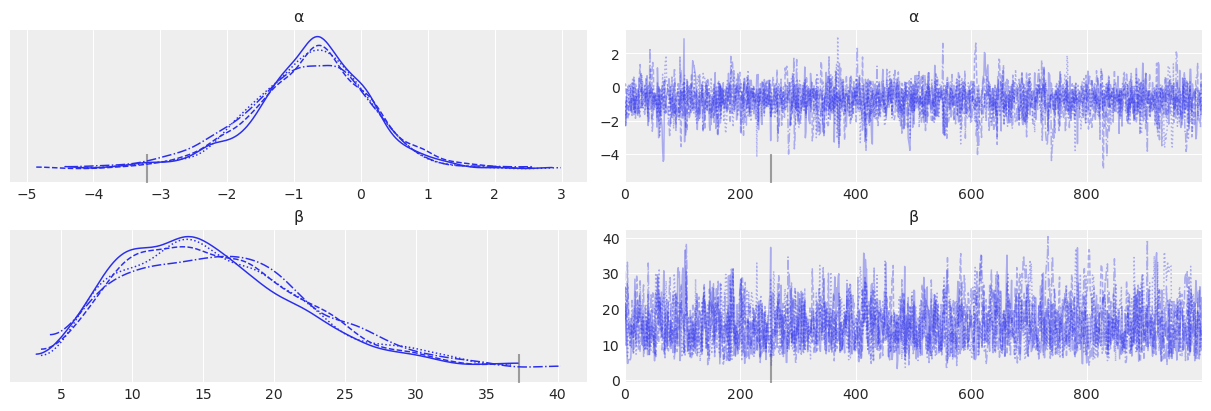

In [44]:
az.plot_trace(idata_rlg, varnames);

In [45]:
varnames = ['α', 'β', 'bd']
az.summary(idata_rlg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.780,0.910,-2.522,0.914,0.020,0.016,2048.0,1911.0,1.0
β,15.865,6.347,4.926,27.233,0.170,0.126,1486.0,1360.0,1.0
bd,0.047,0.056,-0.068,0.146,0.001,0.001,2852.0,2241.0,1.0


C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


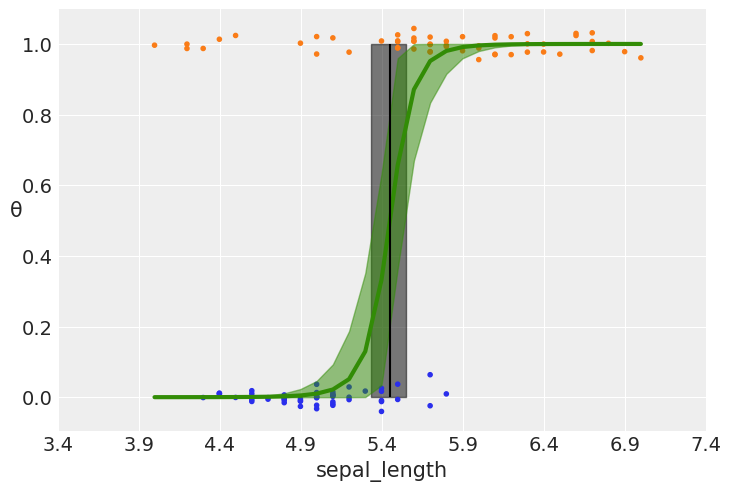

In [46]:
posterior_rlg = idata_rlg.posterior.stack(samples=("chain", "draw"))

theta = posterior_rlg['θ'].mean("samples")
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(posterior_rlg['bd'].mean(), 0, 1, color='k')
bd_hdi = az.hdi(posterior_rlg['bd'].values)
plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, posterior_rlg['θ'].T, color='C2', smooth=False)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));